<a href="https://colab.research.google.com/github/Murarin8877/Business-Intelligence/blob/main/LSTM_Business_Intelligence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#說明:使用一個溫度特徵值預測未來溫度值

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#讀取資料

In [ ]:
data_f=pd.read_csv("DailyDelhiClimateTrain.csv")
data_f.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [ ]:
test_f=pd.read_csv("DailyDelhiClimateTest.csv")
test_f.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


#資料前處理


In [ ]:
#遺失值檢查
data_f.isnull().sum()
test_f.isnull().sum()

,0
date,0
meantemp,0
humidity,0
wind_speed,0
meanpressure,0


##特徵值

In [ ]:
#設置xlabel,ylabel和將訓練數據 (data_f) 和測試數據 (test_f) 的時間步長與溫度值合併，以便後續可視化或分析。
#特徵值只使用溫度值
time_step=np.arange(0,len(data_f))
train_y=data_f["meantemp"]
test_x=np.arange(len(data_f),len(data_f)+len(test_f))
test_y=test_f["meantemp"]

all_meantemp=np.concatenate((train_y,test_y))
all_time=np.concatenate((time_step,test_x))

print(f'train dataset shape:{data_f.shape}')
print(f'test dataset shape:{test_f.shape}')
print(f'train_y shape: {train_y.shape}')
print(f'test_y shape: {test_y.shape}')

train dataset shape:(1462, 5)
test dataset shape:(114, 5)
train_y shape: (1462,)
test_y shape: (114,)


##可視化溫度走勢圖

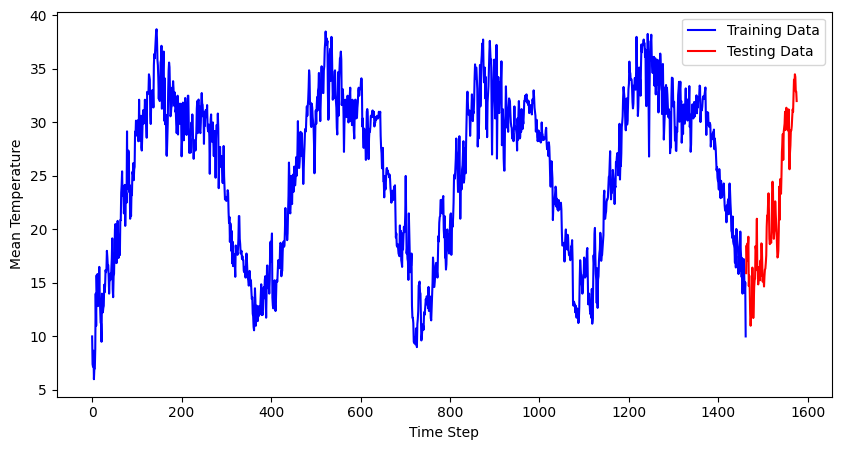

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(time_step, train_y, label="Training Data", color='blue')
plt.plot(test_x, test_y, label="Testing Data", color='red')
plt.xlabel("Time Step")
plt.ylabel("Mean Temperature")
plt.legend()
plt.show()

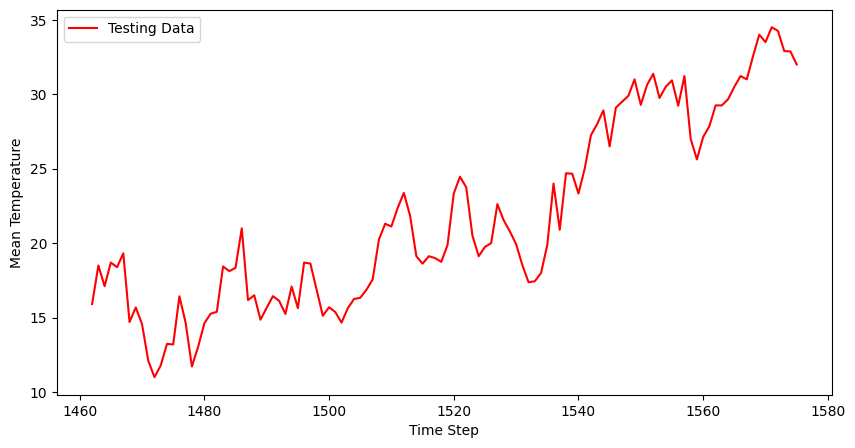

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(test_x, test_y, label="Testing Data", color='red')
plt.xlabel("Time Step")
plt.ylabel("Mean Temperature")
plt.legend()
plt.show()

##建構時間序列資料

In [ ]:
import tensorflow as tf
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Add an axis for the feature dimension of RNN layers
    series = tf.expand_dims(series, axis=-1)

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache().prefetch(1)
    return dataset


#模型創建和訓練

In [ ]:
import tensorflow as tf

# Parameters
window_size = 60
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(train_y, window_size, batch_size, shuffle_buffer_size)
test_set = windowed_dataset(valid_y, window_size, batch_size, shuffle_buffer_size)

In [ ]:
# 建立 LSTM 模型
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size, 1)),  # LSTM 輸入形狀 (時間步長, 特徵數)

    # 第一層 LSTM (return_sequences=True 保留完整序列以供下一層使用)
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, activation="tanh")),

    # 第二層 LSTM (仍然返回完整序列，適用於深度 LSTM)
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, activation="tanh")),

    # 第三層 LSTM (不返回序列，準備接 Fully Connected 層)
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation="tanh")),

    # Dropout 層以減少過擬合
    tf.keras.layers.Dropout(0.2),

    # 全連接層
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),

    # 最終輸出層
    tf.keras.layers.Dense(1),  # 單一數值輸出 (未來某個時間點的預測值)

    # 縮放輸出
    tf.keras.layers.Lambda(lambda x: x * 100)
])

# 顯示模型摘要
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 60, 128)             │          33,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 60, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 180,609 (705.50 KB)

 Trainable params: 180,609 (705.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",  # 均方誤差（MSE），適用於回歸問題
    metrics=["mae"]  # 平均絕對誤差（MAE）
)

# 開始訓練
history = model.fit(train_set, epochs=50,verbose=1)

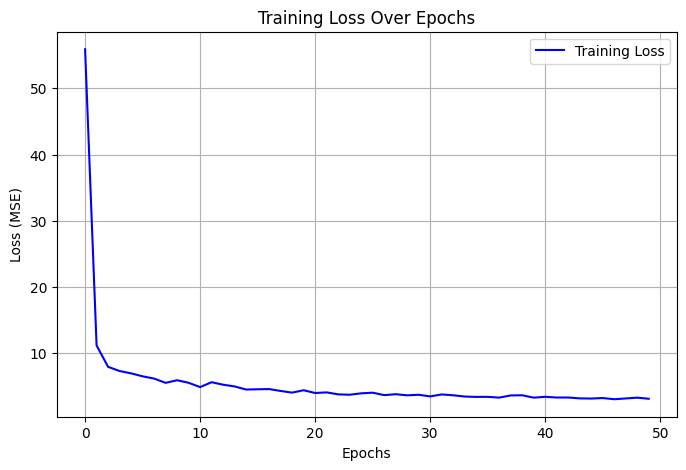

In [ ]:
# 繪製 Loss 變化
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label="Training Loss", color='blue')
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

#測試

In [ ]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Add an axis for the feature dimension of RNN layers
    series = tf.expand_dims(series, axis=-1)

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(1)
    forecast = model.predict(dataset, verbose=0)

    return forecast

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


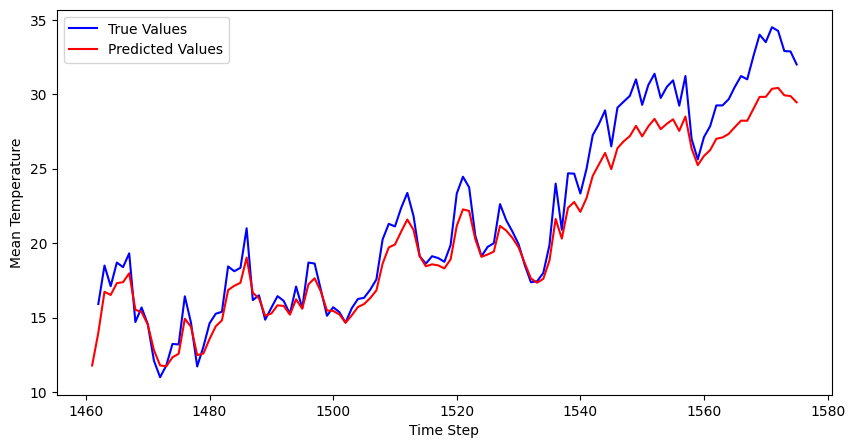

In [ ]:
import matplotlib.pyplot as plt
# Use helper function to generate predictions
forecast = model_forecast(model, all_meantemp ,window_size, batch_size)
# Drop single dimensional axis
results = forecast.squeeze()

plt.figure(figsize=(10,5))
plt.plot(test_x, test_y, label="True Values", color='blue')
plt.plot(all_time[-115:],results[-115:], label="Predicted Values", color='red')
plt.xlabel("Time Step")
plt.ylabel("Mean Temperature")
plt.legend()
plt.show()

In [ ]:
print(f"valid_x shape: {test_x.shape}")
print(f"valid_y shape:{test_y.shape}")
print(f"all_meantemp shape: {all_meantemp.shape}")
print(f"results shape: {results.shape}")

valid_x shape: (114,)
valid_y shape:(114,)
all_meantemp shape: (1576,)
results shape: (1517,)


#評估指標

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 計算評估指標
mse = mean_squared_error(test_y, results[-len(test_y):])  # 確保長度匹配
mae = mean_absolute_error(test_y, results[-len(test_y):])
r2 = r2_score(test_y, results[-len(test_y):])

# 回傳評估結果
mse, mae, r2
print(f'MSE: {mse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'R2: {r2:.2f}')

MSE: 2.95
MAE: 1.35
R2: 0.93
